# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***LIBRARIES***

In [ ]:
import torch
import os
import torch.nn as nn
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

#torch.manual_seed(123)
np.random.seed(123)

# ***MODEL***

In [ ]:
# Define the ABU activation function for the SABR PDE
class SinSoftplusActivation(nn.Module):
    def forward(self, input):
        new_act_f = 0.005*torch.sin(input) + 1*torch.nn.functional.softplus(input) + 0*torch.nn.functional.tanh(input) + 0.00*torch.nn.functional.gelu(input)
        return new_act_f

In [ ]:
class Alternative_FCN(nn.Module):
    def __init__(self):
        super(Alternative_FCN, self).__init__()
        self.bn1 = nn.BatchNorm1d(2)
        self.fc1 = nn.Linear(2, 200)
        self.act1 = SinSoftplusActivation()
        self.bn2 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.act2 = SinSoftplusActivation()
        self.bn3 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.act3 = SinSoftplusActivation()
        self.bn4 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 200)
        self.act4 = SinSoftplusActivation()
        self.bn5 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200, 200)
        self.act5 = SinSoftplusActivation()
        self.bn6 = nn.BatchNorm1d(200)
        self.fc6 = nn.Linear(200, 1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        return x

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[2.0, 149.5])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.1, 149.7])


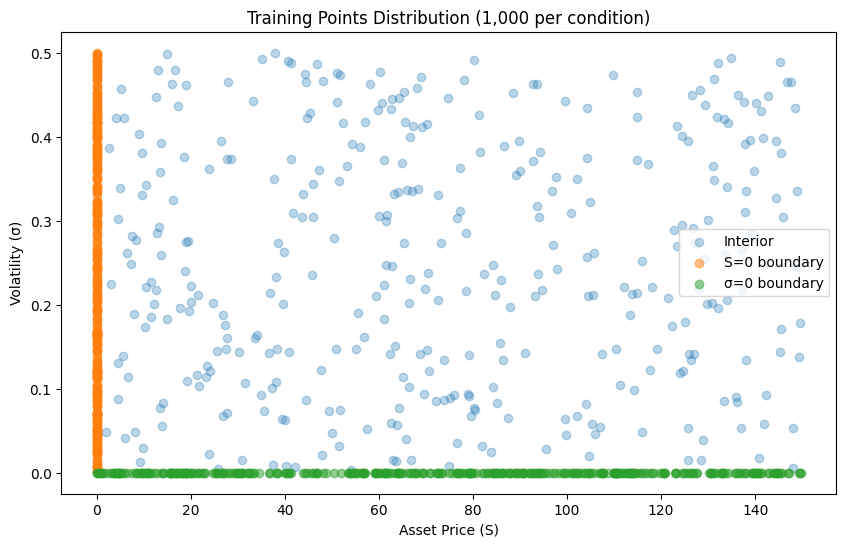

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

# ***PDE AND PINN CONDITIONS***

In [ ]:
# Black-Scholes PDE
def BS_pde_residual(model, S, t, sigma, r):
    C = model(torch.cat([S, t], dim=1))
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    pde = C_t + 0.5 * sigma**2 * S**2 * C_SS + r * S * C_S - r * C
    return pde

# Black-Scholes boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min)  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

def Smax_conditions(model, inputs_S_max, K, r):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    Smax_t = inputs_S_max[:, 1].requires_grad_(True).reshape(-1, 1)

    V_S_max = model(inputs_S_max)
    boundary_S_max = V_S_max - fSmax +  K * torch.exp(-r * (Smax_t))
    boundary_S_max = torch.mean(boundary_S_max**2)

    return boundary_S_max

def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0))
    return val.view(-1, 1).requires_grad_(True)

# ***ANALYTICAL BS - MANTO CARLO - SABR PATH GENERATION***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# SABR PATH SIMULATION

def simulate_sabr_path(beta, nu, rho,
                       F0, sigma0, strike_price,
                       T, N, r, plot=True):
    np.random.seed(123)
    dt = T / N
    dW1 = np.random.normal(0, np.sqrt(dt), N)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), N)

    if plot:
        plt.plot(dW1, label='dW1')
        plt.plot(dW2, label='dW2')
        plt.title("Brownian Motions")
        plt.xlabel("Steps (N)")
        plt.ylabel("W_1 and W_2")
        plt.legend()
        plt.show()

    F = np.zeros(N)
    sigma = np.zeros(N)
    F[0] = F0
    sigma[0] = sigma0

    for t in range(1, N):
        #discount_F = F0 * np.exp(r * (t-1))
        F[t] = F[t-1] + sigma[t-1] * (F[t-1])**beta * dW1[t-1]
        sigma[t] = sigma[t-1] + nu * sigma[t-1] * dW2[t-1]

    return F, sigma

# MONTE CARLO OPTION PRICE

def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices



# ***TRAINING***

Iteration 0, Loss: 722175.625
Loss-1 (IC): 3000.235107421875, Loss-2 (pde): 0.00022019217431079596 , Loss-5 (bd): 719175.375
LR: 2.00e-04
Iteration 100, Loss: 3251.5244140625
Loss-1 (IC): 3091.9541015625, Loss-2 (pde): 0.004043021239340305 , Loss-5 (bd): 159.5662841796875
LR: 2.00e-04
Iteration 200, Loss: 3218.0615234375
Loss-1 (IC): 3156.897705078125, Loss-2 (pde): 0.015454774722456932 , Loss-5 (bd): 61.14839553833008
LR: 2.00e-04
Iteration 300, Loss: 3230.46337890625
Loss-1 (IC): 3173.806640625, Loss-2 (pde): 0.16616396605968475 , Loss-5 (bd): 56.49039077758789
LR: 2.00e-04
Iteration 400, Loss: 3135.634033203125
Loss-1 (IC): 3074.4775390625, Loss-2 (pde): 0.18990585207939148 , Loss-5 (bd): 60.96647644042969
LR: 2.00e-04
Iteration 500, Loss: 3169.222412109375
Loss-1 (IC): 3139.22998046875, Loss-2 (pde): 0.4519540071487427 , Loss-5 (bd): 29.540550231933594
LR: 2.00e-04
Iteration 600, Loss: 3052.71484375
Loss-1 (IC): 3037.122314453125, Loss-2 (pde): 1.496970295906067 , Loss-5 (bd): 14.0

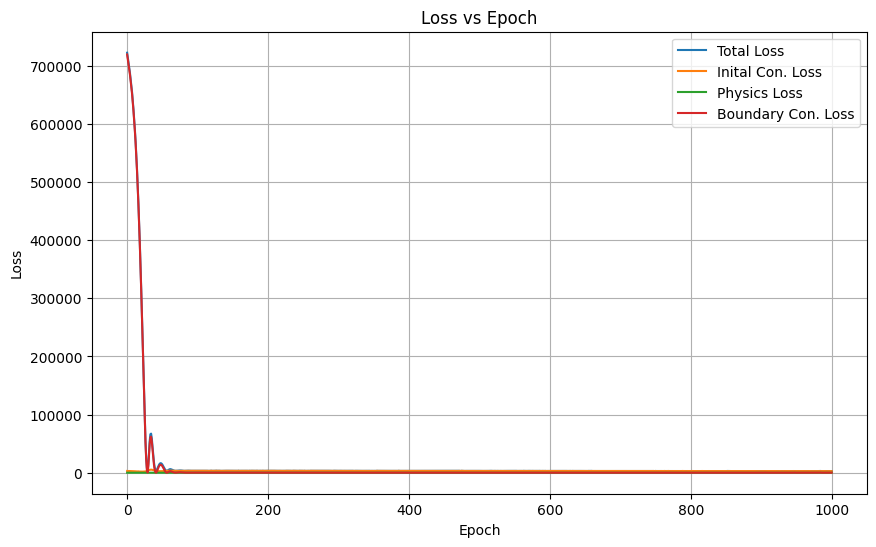

In [ ]:
# SABR parameters
beta = 1
nu = 0
rho = -0.2
strike_price = 50
T = 1.0  # time
N = 365  # time step
F0 = 100  # Initial Forward Price
sigma0 = 0.25  # Volatilite
r=0.05

F, sigma = simulate_sabr_path(beta, nu, rho, F0, sigma0, strike_price, T, N, r, plot=False)

F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

lambda1, lambda2 = 1, 1

model = Alternative_FCN()
optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=200,
    min_lr=2e-5)

best_loss = float('inf')
save_path = 'best_model.pth'

totallosses=[]
Lic_list = []
Lpde_list = []
Lbd_list = []
Lbd_Smax_list = []
Lbd_S0_list = []
Lbd_Vmax_list = []
Lbd_V0_list = []

# Compute model

for i in range(1000):
    data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

    t0 = data['initial'].clone().detach().requires_grad_(True)
    S0 = data['bd_S0'].clone().detach().requires_grad_(True)
    Smax = data['bd_Smax'].clone().detach().requires_grad_(True)
    inputs = data['interior'].clone().detach().requires_grad_(True)
    inputs_all = data['all'].clone().detach().requires_grad_(True)

    t0_bs = torch.cat([t0[:, 0].requires_grad_(True).reshape(-1, 1), t0[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1)


    C0 = model(t0_bs)
    loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1), strike_price))**2
    Lic = lambda1 * loss1.mean()

    # Compute the PDE residual as the loss
    residual = BS_pde_residual(model, inputs[:,0].requires_grad_(True).reshape(-1, 1), inputs[:,2].requires_grad_(True).reshape(-1, 1), inputs[:,1].requires_grad_(True).reshape(-1, 1), r)
    Lpde = lambda2 * torch.mean(residual**2)

    S0_bs = torch.cat([S0[:, 0].requires_grad_(True).reshape(-1, 1), S0[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1)
    bnd_S_min = Smin_conditions(model, S0_bs)

    Smax_bs = torch.cat([Smax[:, 0].requires_grad_(True).reshape(-1, 1), Smax[:, 2].requires_grad_(True).reshape(-1, 1)], dim=1)
    bnd_S_max = Smax_conditions(model, Smax_bs, strike_price, r)


    Lbd = ( 100*bnd_S_max + 1*bnd_S_min )
    Lic2 = 2*Lic
    Lpde2 = 1*Lpde
    loss = Lic2 + Lpde2 + Lbd

    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step(loss)
    optimizer.zero_grad()

    totallosses.append(loss.item())
    Lic_list.append(Lic2.item())
    Lpde_list.append(Lpde2.item())
    Lbd_list.append(Lbd.item())
    Lbd_Smax_list.append(100*bnd_S_max.item())
    Lbd_S0_list.append(1*bnd_S_min.item())

    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
        print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
        current_lr = optimizer.param_groups[0]['lr']
        print(f'LR: {current_lr:.2e}')

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'iteration': i
            }, save_path)

print("best loss: ", best_loss )

checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(totallosses)), totallosses, label='Total Loss')
plt.plot(range(len(totallosses)), Lic_list, label='Inital Con. Loss')
plt.plot(range(len(totallosses)), Lpde_list, label='Physics Loss')
plt.plot(range(len(totallosses)), Lbd_list, label='Boundary Con. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.grid(True)
plt.legend()
plt.show()


# ***Result on Syntetic Dataset by using SABR Path***




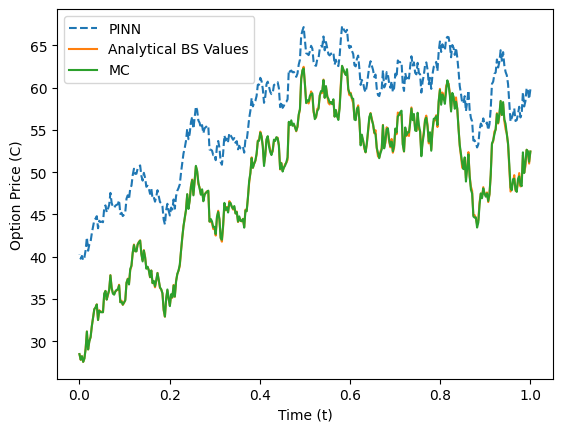

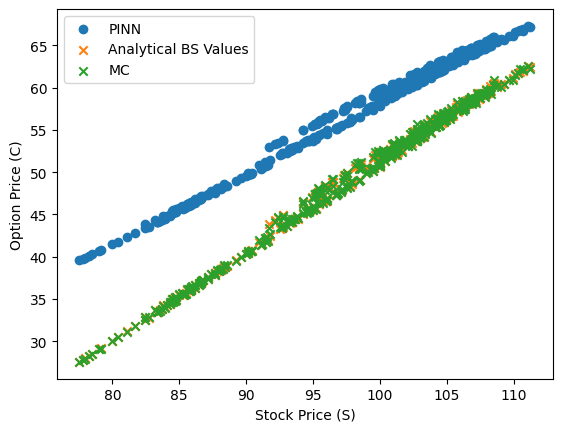

In [ ]:
beta =1
nu = 0.
rho = -0.2
strike_price = 50
T = 1.0
N = 365
F0 = 100
sigma0 = 0.25
r=0.05

F, sigma = simulate_sabr_path(beta, nu, rho, F0, sigma0, strike_price, T, N, r, plot=False)

time_np = np.linspace(0, T, N)
time = np.flip(time_np).copy()

F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)
inputs_bs = torch.cat([F_torch, time_torch], dim=1)

C = model(inputs_bs) # PINN OPTION PRICES
C = C.detach().numpy()

bs_op_pr = black_scholes_option_price(F, strike_price, time, r, sigma) # ANALYTICAL BS OPTION PRICES

mc = sabr_european_call_mc(F, sigma, time, strike_price, r, beta, nu, rho=-0.2, N=100, M=10000, confidence=0.95)

plt.plot(time, C, label="PINN", linestyle='dashed')
plt.plot(time, bs_op_pr, label="Analytical BS Values")
plt.plot(time, mc, label="MC")
plt.xlabel("Time (t)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()

plt.scatter(F, C, label="PINN", marker='o')
plt.scatter(F, bs_op_pr, label="Analytical BS Values", marker="x")
plt.scatter(F, mc, label="MC", marker="x")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()


# ***RESULTS ON RANDOM DATASET***

In [ ]:
loss_df = pd.DataFrame(columns=["Total", "ic", "bd", "phy","Smax", "S0"])

# Output directory to save the plots
output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/BS/simulations"
os.makedirs(output_dir, exist_ok=True)

loss_df = pd.DataFrame({
    "Total": totallosses,
    "ic": Lic_list,
    "bd": Lbd_list,
    "phy": Lpde_list,
    "Smax": Lbd_Smax_list,
    "S0": Lbd_S0_list
})

excel_path = os.path.join(output_dir, "loss.xlsx")

loss_df.to_excel(excel_path, index=False)

print(f"Results saved to : {excel_path}")

Results saved to : /content/drive/MyDrive/Bitirme_real_dataset/new/BS/simulations/loss.xlsx


In [ ]:
# Load all sheets
excel_file = "/content/drive/MyDrive/Bitirme_real_dataset/option_price_comparison_beta1_nu0.xlsx"
df = pd.read_excel(excel_file)

# DataFrame to store the MSE and MAPE values for each sheet
prediction_df = pd.DataFrame(columns=["Prediction", "MC", "BS", "S", "Sigma", "t"])

# Output directory to save the plots
output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/BS/simulations"
os.makedirs(output_dir, exist_ok=True)


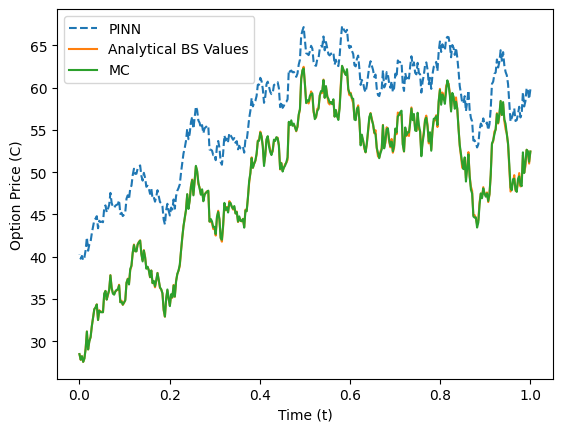

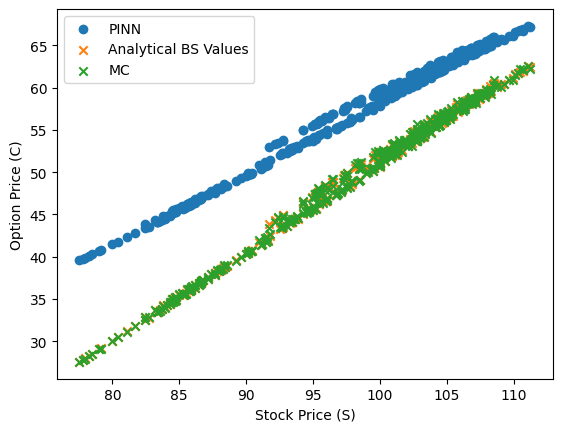

In [ ]:
strike_price = 50
r=0.05

F = df['S'].values
sigma = df['Sigma'].values
mc_prices = df['MC'].values
bs_prices = df['BS'].values
time = df['t'].values

F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)

inputs_bs = torch.cat([F_torch, time_torch], dim=1)

C = model(inputs_bs) # PINN OPTION PRICES
C = C.detach().numpy()

plt.plot(time, C, label="PINN", linestyle='dashed')
plt.plot(time, bs_prices, label="Analytical BS Values")
plt.plot(time, mc_prices, label="MC")
plt.xlabel("Time (t)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()

plt.scatter(F, C, label="PINN", marker='o')
plt.scatter(F, bs_prices, label="Analytical BS Values", marker="x")
plt.scatter(F, mc_prices, label="MC", marker="x")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Price (C)")
plt.legend()
plt.show()


In [ ]:
prediction_df = pd.DataFrame({
    "Prediction": C.flatten(),
    "MC": mc_prices,
    "BS": bs_prices,
    "S": F,
    "Sigma": sigma,
    "t": time
})

excel_path = os.path.join(output_dir, "option_price_comparison_syn.xlsx")

prediction_df.to_excel(excel_path, index=False)

print(f"Results saved to : {excel_path}")

Results saved to : /content/drive/MyDrive/Bitirme_real_dataset/new/BS/simulations/option_price_comparison_syn.xlsx


In [ ]:
# Load all sheets
excel_file2 = "/content/drive/MyDrive/Bitirme_real_dataset/option_price_comparison_random.xlsx"
df2 = pd.read_excel(excel_file2)

F = df2['S'].values  # SPOT PRICE
sigma = df2['Sigma'].values
mc_prices = df2['MC'].values
bs_prices = df2['BS'].values
time = df2['t'].values

F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)

inputs_bs_random = torch.cat([F_torch, time_torch], dim=1)

predictionrandom_df = pd.DataFrame(columns=["Prediction", "MC", "BS", "S", "Sigma", "t"])

output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/BS/simulations"
os.makedirs(output_dir, exist_ok=True)

C = model(inputs_bs_random)
C = C.detach().numpy()

C = C.reshape(-1)

In [ ]:
predictionrandom_df = pd.DataFrame({
    "Prediction": C.flatten(),
    "MC": mc_prices,
    "BS": bs_prices,
    "S": F,
    "Sigma": sigma,
    "t": time
})

excel_path = os.path.join(output_dir, "option_price_comparison_rnd.xlsx")
predictionrandom_df.to_excel(excel_path, index=False)

print(f"Results saved to : {excel_path}")

Results saved to : /content/drive/MyDrive/Bitirme_real_dataset/new/BS/simulations/option_price_comparison_rnd.xlsx
